In [1]:
import numpy as np
import teneva
from time import perf_counter as tpc
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from layers.helpers.astralora_bb import MatrixFactorizationALS

    

np.random.seed(42)

In [2]:
# train data
# matrix_size = 10000
# n_samples = 2000
# appr_rank = 500
matrix_size = 100
n_samples = 2000
appr_rank = 10


# generate random matrix
A = np.random.rand(matrix_size, matrix_size)

def generate_dataset(n_samples, matrix_size, A):
    X = np.random.rand(n_samples, matrix_size)
    Y = X @ A
    return X, Y

X, Y = generate_dataset(n_samples, matrix_size, A)


# GD

In [10]:
def train_gd(X, Y, matrix_size, appr_rank, device='cpu', learning_rate=0.001, n_epochs=10000, batch_size=2000):
    # Initialize random matrices U and V such that A ≈ UV^T
    
    U = torch.tensor(np.random.randn(matrix_size, appr_rank), requires_grad=True, device=device)
    V = torch.tensor(np.random.randn(matrix_size, appr_rank), requires_grad=True, device=device)
    X_tensor = torch.tensor(X, device=device)
    Y_tensor = torch.tensor(Y, device=device)

    # Create data loader for mini-batches
    dataset = torch.utils.data.TensorDataset(X_tensor, Y_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize optimizer
    optimizer = torch.optim.Adam([U, V], lr=learning_rate)

    # For tracking loss history
    losses = []

    # Training loop
    
    for epoch in tqdm(range(n_epochs), desc='Training'):
        epoch_loss = 0
        batch_count = 0
        
        for X_batch, Y_batch in dataloader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Compute predictions
            Y_pred = X_batch @ U @ V.T
            
            # Compute loss
            loss = torch.mean((Y_pred - Y_batch) ** 2)
            epoch_loss += loss.item()
            batch_count += 1
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()
        
        # Average loss over batches
        avg_epoch_loss = epoch_loss / batch_count
        losses.append(avg_epoch_loss)
        
        # # Print loss every 100 epochs
        # if (epoch + 1) % 100 == 0:
        #     print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_epoch_loss:.6f}')

    

    # Reconstruct approximated A and move to CPU if needed
    U = U.cpu()
    V = V.cpu()
    A_approx_grad = (U @ V.T).detach().numpy()
    
    return A_approx_grad, U.detach().numpy(), V.detach().numpy(), losses


In [11]:
t = tpc()

A_approx_grad, U, V, losses = train_gd(X, Y, matrix_size, appr_rank)

train_time = tpc() - t
print(f'\nTraining time: {train_time:.2f} seconds')

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(losses, '-b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Convergence')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

Training:   0%|          | 0/10000 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2000x100 and 5000x500)

In [25]:
# Compute predictions on training set
Y_pred_grad = X @ U.detach().numpy() @ V.detach().numpy().T
train_mse = np.mean((Y_pred_grad - Y) ** 2).item()
print(f'Training MSE: {train_mse:.6f}')


# Compute relative error
rel_error = np.linalg.norm(A_approx_grad - A) / np.linalg.norm(A)
print(f'Relative error: {rel_error:.6f}')


Training MSE: 0.822197
Relative error: 0.550204


# ALS

In [11]:
device = torch.device('cuda:1')
X_tensor = torch.tensor(X, device=device)
Y_tensor = torch.tensor(Y, device=device)

# Create ALS model and fit
als_model = MatrixFactorizationALS(
    rank=appr_rank, 
    max_iter=100, 
    tol=1e-6,
    random_state=42, 
    device=device
)

# Fit the model
als_model.fit(X_tensor, Y_tensor, verbose=True, minibatch_size=2000)








Iteration 0: Loss = 0.684690
Iteration 10: Loss = 0.480302
Iteration 20: Loss = 0.476199
Iteration 30: Loss = 0.475446
Iteration 40: Loss = 0.475301
Iteration 50: Loss = 0.475268


KeyboardInterrupt: 

In [28]:
# Get the factorization B, C where Y ≈ X @ B @ C
B, C = als_model.get_factorization()

A_approx_als = als_model.reconstruct_A()

# Get predictions on training set
Y_pred_als = als_model.predict(X_np)

# Compute MSE
mse = np.mean((Y_np - Y_pred_als) ** 2)
print(f'Training MSE: {mse:.6f}')

# Compute relative error
rel_error = np.linalg.norm(A_approx_als - A) / np.linalg.norm(A)
print(f'Relative error: {rel_error:.6f}')

Training MSE: 0.476506
Relative error: 0.421435


In [29]:
# Compute SVD of A
U_svd, S_svd, Vh_svd = np.linalg.svd(A)

# Crop to rank
U_svd_cropped = U_svd[:, :appr_rank]
S_svd_cropped = S_svd[:appr_rank]
Vh_svd_cropped = Vh_svd[:appr_rank, :]

# Reconstruct approximation
A_approx_svd = U_svd_cropped @ np.diag(S_svd_cropped) @ Vh_svd_cropped

# Compute relative error
rel_error_svd = np.linalg.norm(A_approx_svd - A) / np.linalg.norm(A)
print(f'SVD relative error: {rel_error_svd:.6f}')


SVD relative error: 0.418738


# Relative errors wrt to the number of samples

/tmp/ipykernel_2928524/1718330977.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, device=device)
/tmp/ipykernel_2928524/1718330977.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y, device=device)


Iteration 0: Loss = 0.000000
Converged at iteration 1
Samples: 100, ALS relative error: 0.950188


Training: 100%|██████████| 1000/1000 [00:01<00:00, 760.79it/s]


Relative error: 9.117118
Iteration 0: Loss = 665.870985
Iteration 10: Loss = 476.478338
Converged at iteration 17
Samples: 500, ALS relative error: 0.908735


Training: 100%|██████████| 1000/1000 [00:03<00:00, 267.33it/s]


Relative error: 6.162340
Iteration 0: Loss = 749.862090
Iteration 10: Loss = 574.429806
Converged at iteration 17
Samples: 1000, ALS relative error: 0.871790


Training: 100%|██████████| 1000/1000 [00:07<00:00, 136.29it/s]


Relative error: 3.155473


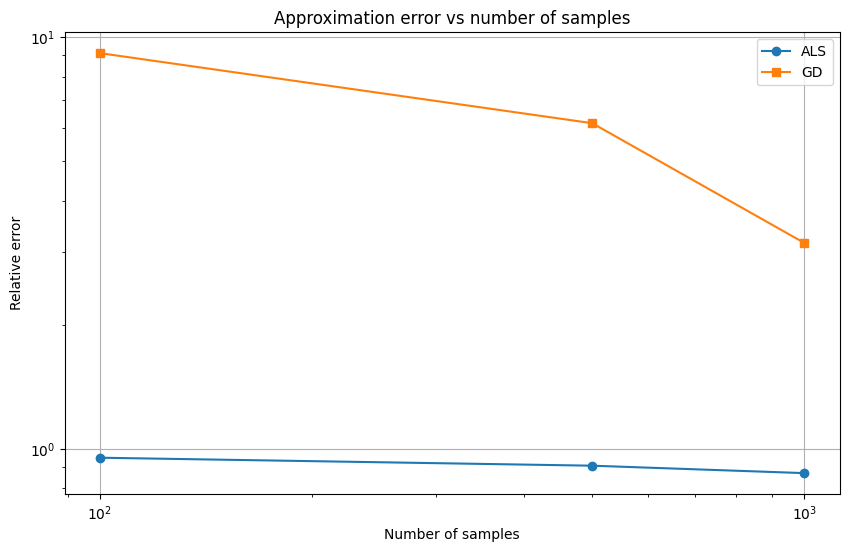

In [20]:
with torch.no_grad():
    # Define sample sizes to test
    sample_sizes = [100, 500, 1000]#, 2500, 5000]
    matrix_size = 1024
    appr_rank = 100

    # Store results
    als_errors = []
    gd_errors = []

    device = torch.device('cuda:1')
    A = np.random.randn(matrix_size, matrix_size)
    A_torch = torch.tensor(A, device=device)

    # Run experiments for each sample size
    for n_samples in sample_sizes:
        # Generate random input samples
        X_np = np.random.randn(n_samples, matrix_size)
        Y_np = X_np @ A
        
        # Convert to torch tensors on GPU
        X_torch = torch.tensor(X_np, device=device)
        Y_torch = torch.tensor(Y_np, device=device)
        
        # Create and fit ALS model
        als_model = MatrixFactorizationALS(
            rank=appr_rank,
            max_iter=100,
            tol=1e-1,
            random_state=42,
            device=device
        )
        als_model.fit(X_torch, Y_torch, verbose=True, minibatch_size=n_samples)
        
        # Get approximation and compute error
        A_als = als_model.reconstruct_A().cpu().numpy()
        rel_error = np.linalg.norm(A_als - A) / np.linalg.norm(A)
        als_errors.append(rel_error)
        
        print(f'Samples: {n_samples}, ALS relative error: {rel_error:.6f}')

        # compute with gd
        with torch.enable_grad():
            A_approx_grad, U, V, losses = train_gd(X_torch, Y_torch, matrix_size, appr_rank, device=device, n_epochs=1000, batch_size=500)
        # Compute relative error
        rel_error = np.linalg.norm(A_approx_grad - A) / np.linalg.norm(A)
        gd_errors.append(rel_error)
        print(f'Relative error: {rel_error:.6f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, als_errors, 'o-', label='ALS')
plt.plot(sample_sizes, gd_errors, 's-', label='GD')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Relative error')
plt.title('Approximation error vs number of samples')
plt.grid(True)
plt.legend()
plt.show()


In [21]:
# Compute true SVD of A and get truncated reconstruction
U_true, S_true, Vh_true = np.linalg.svd(A)
A_svd = U_true[:, :appr_rank] @ np.diag(S_true[:appr_rank]) @ Vh_true[:appr_rank, :]
svd_error = np.linalg.norm(A_svd - A) / np.linalg.norm(A)
print(f'SVD relative error: {svd_error:.6f}')





SVD relative error: 0.832190


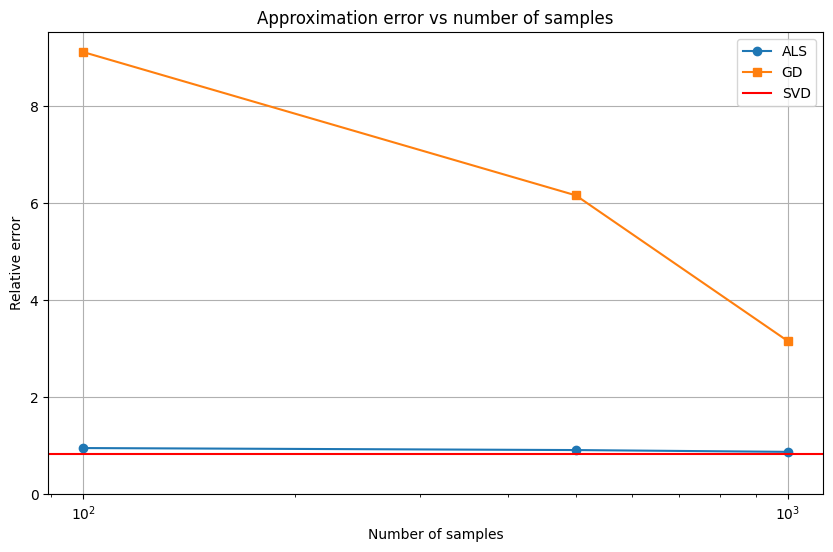

In [24]:
# Update plot to include SVD results
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, als_errors, 'o-', label='ALS')
plt.plot(sample_sizes, gd_errors, 's-', label='GD')
plt.axhline(y=svd_error, color='r', linestyle='-', label='SVD')
plt.xscale('log')
plt.ylim(bottom=0)

# plt.yscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Relative error')
plt.title('Approximation error vs number of samples')
plt.grid(True)
plt.legend()
plt.show()

# Cross (ne nado)

In [4]:
# m         = n_samples  # Number of calls to target function
# e         = None   # Desired accuracy
# nswp      = None   # Sweep number
# r         = 500      # TT-rank of the initial tensor
# dr_min    = 0      # Cross parameter (minimum number of added rows)
# dr_max    = 0      # Cross parameter (maximum number of added rows)

In [5]:
# t = tpc()
# info, cache = {}, {}
# Y = teneva.rand([matrix_size, matrix_size], appr_rank)
# Y = teneva.cross(func, Y, m, e, nswp, dr_min=dr_min, dr_max=dr_max,
#     info=info, cache=cache)
# Y = teneva.truncate(Y, 1.E-4) # We round the result at the end
# t = tpc() - t

# print(f'Build time           : {t:-10.2f}')
# print(f'Evals func           : {info["m"]:-10d}')
# print(f'Cache uses           : {info["m_cache"]:-10d}')
# print(f'Iter accuracy        : {info["e"]:-10.2e}')
# print(f'Sweep number         : {info["nswp"]:-10d}')
# print(f'Stop condition       : {info["stop"]:>10}')
# print(f'TT-rank of pure res  : {info["r"]:-10.1f}')
# print(f'TT-rank of trunc res : {teneva.erank(Y):-10.1f}')